In [21]:
import pandas as pd
import numpy as np
import os
import datetime 
import matplotlib.pyplot as plt
import yfinance as yf

In [22]:
#复权个股日线
start = datetime.datetime(2020,1,1)
end   = datetime.datetime(2026,1,26)

#tc="000001.sz"
tc="1818.HK"
#tc="002493.SZ"
#tc = '600048.SS'
#tc = 'QQQ'

In [23]:
data = yf.download(tc, start, end) #利用 yfinance的python yahoo 库下载历史数据
#--------------------------------------获取复权收盘价------------------------------------------------------------
data = data.rename(columns={ 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'close', 'Volume': 'volume'})
data['date'] = pd.to_datetime(data.index,format='%Y%m%d')
data.set_index('date', inplace=True)
data.columns = data.columns.droplevel(1) #删除多余的列索引层级（注意yahoo 数据源会有多余的列索引层级）!!

#--------------------------------------策略信号------------------------------------------------------------

data['B_close'] = data['close'].shift(1)  #前一日收盘价，去除未来函数影响

data['gr_close'] = data['B_close']/data['B_close'].shift(1)-1 #计算前一日收盘价的涨跌幅
data['gr_close'] = data['gr_close'].fillna(0)

data['rc'] = data['open'] - data['B_close'] #策略信号：计算当日开盘价与前一日收盘价的价差

[*********************100%***********************]  1 of 1 completed


标的:1818.HK
起始日:2020-01-01 00:00:00
终止日:2026-01-26 00:00:00
策略收益率：8.081556215961937
基准收益率：3.603790738153113


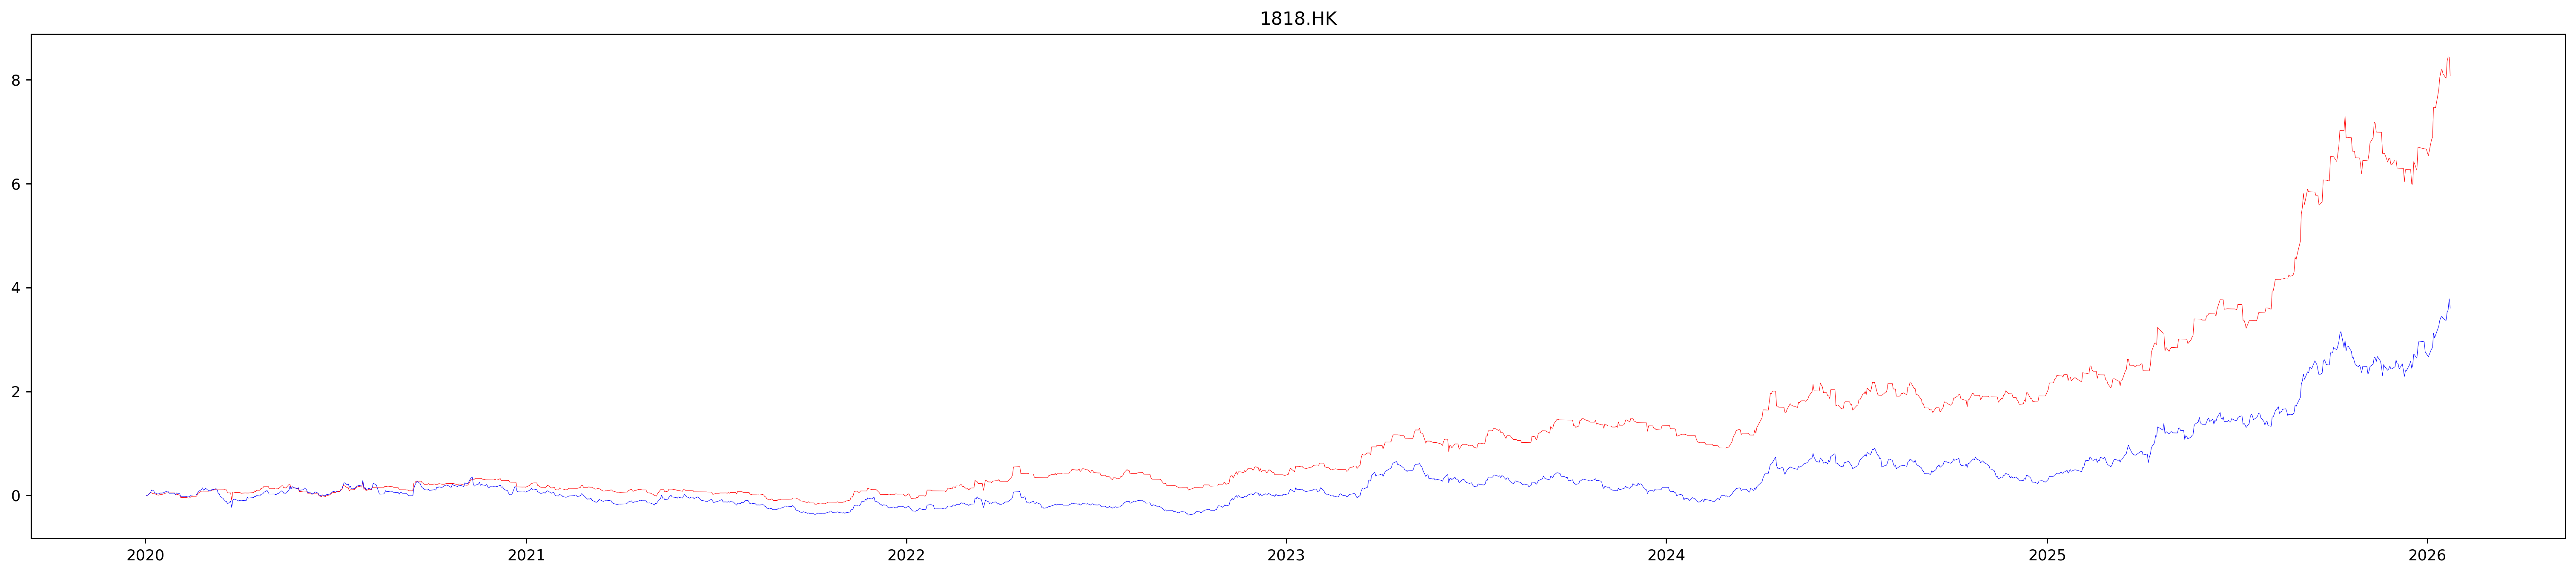

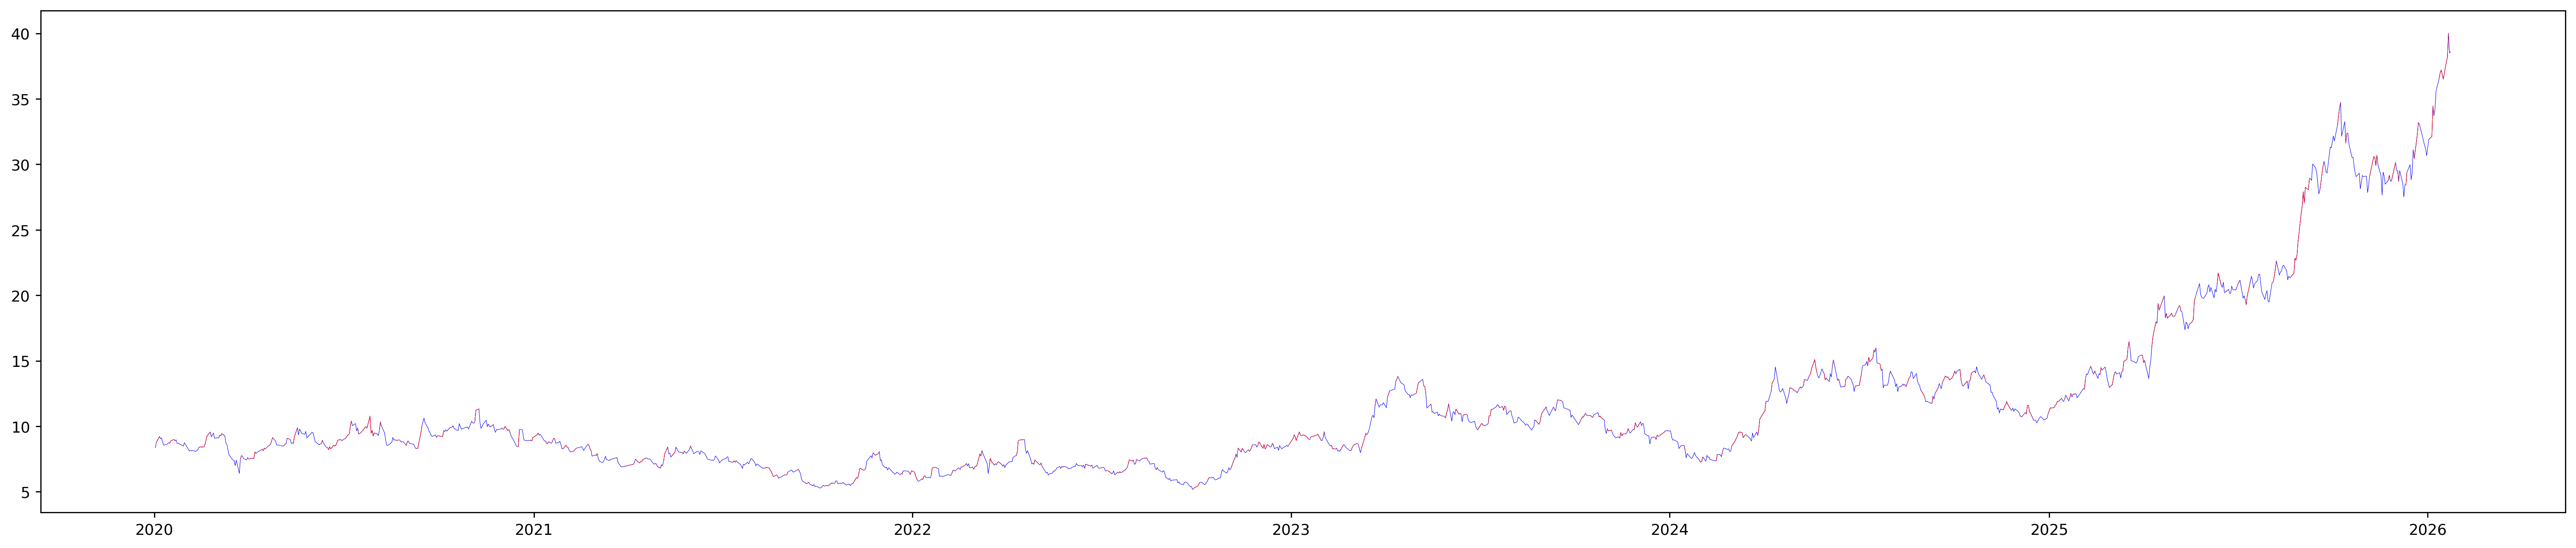

In [24]:
#---------------------------------回测模块-------------------------------------------------
data['ddx'] =  (data['rc'] > 0)  
#---------------------------------回测收益-------------------------------------------------
data['res'] = np.select([data['ddx']> 0],[data['close'].values],default = np.nan)  #获取快慢SSA >0的时序
#data['res'] = np.select([data['ddx'].shift(1) > 0],[data['close']],default = np.nan)  #获取快慢SSA >0的时序

data['attack'] = np.select([data['ddx'] > 0],[1],default = 0)#获取“双SSA斜率差 >0策略”的时序的触发信号


print("标的:"+str(tc))
print("起始日:"+str(start))
print("终止日:"+str(end))

bs = np.array(data['attack'])
#print("买卖信号A:"+str(bs[-1]))

data['buy'] = data['attack']  #买入信号

bs2 = np.array(data['buy'])
#print("买卖信号B:"+str(bs2[-1]))

data['base_profit'] = 1+data['gr_close'].fillna(0) #计算基准每日收益
data['prod_base_profit'] = data['base_profit'].cumprod()-1 #计算基准每日收益累乘
data['profit'] = np.select([data['buy'] == 1],[data['base_profit']],default = 1) #计算策略每日收益
data['profit'] = data['profit'].fillna(0)*0.9998
data['prod_profit'] = data['profit'].cumprod()-1#计算策略每日收益累乘

plt.fig = plt.figure(figsize=(30,6), dpi=256)
plt.title(str(tc))
plt.plot(data['prod_profit'], color="red", linewidth=0.3, linestyle="-")
plt.plot(data['prod_base_profit'], color = "blue",  linewidth=0.3, linestyle="-")

print("策略收益率："+str(np.array(data['prod_profit'])[-1])) 
print("基准收益率："+str(np.array(data['prod_base_profit'])[-1]))

plt.figure(figsize=(30,6), dpi=256)
plt.plot(data['close'], color = "blue",  linewidth=0.3, linestyle="-")
plt.plot(data['res'], color = "red",  linewidth=0.3, linestyle="-")